There are various places to get a pretrained model, such as: 
1. PyTorch domain libraries 
2. Libraries like timm 
3. HuggingFace Hub 
4. Paperswithcode 

https://pytorch.org/vision/stable/models.html

In [1]:
import torch 
import torchvision 
from torch import nn 

from torchinfo import summary 
import matplotlib.pyplot as plt 

from going_modular import data_setup, engine 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device 

'cpu'

In [3]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [4]:
auto_transforms = weights.transforms() 
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
from going_modular import data_setup 

train_dir = 'data/pizza_steak_sushi/train'
test_dir = 'data/pizza_steak_sushi/test' 

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, auto_transforms, 32) 
train_dataloader, test_dataloader, class_names 

(<torch.utils.data.dataloader.DataLoader at 0x18ac7c07690>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# old method of creating a pretrained model (prior to torchvision v0.13) 
# model = torchvision.models.efficientnet_b0(pretrained=True)  

# new method of creating a pretrained model (torchvision v0.13+) 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights) 
model  

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\jusung/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:12<00:00, 1.72MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
model.features  # feature extractor 

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [10]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
from torchinfo import summary 

summary(model=model, 
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [16]:
for param in model.features.parameters(): 
    param.requires_grad = False 

In [17]:
summary(model=model, 
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [18]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [19]:
model.classifier[1] 

Linear(in_features=1280, out_features=1000, bias=True)

In [20]:
model.classifier[1].out_features=3 
model.classifier 

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [26]:
from torch import nn 

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True) 
) 

model.classifier 

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [27]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [28]:
from going_modular import engine 
from timeit import default_timer as timer 

torch.manual_seed(42) 
torch.cuda.manual_seed(42) 

start_time = timer() 
results = engine.train(model=model, 
                       train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader, 
                       optimizer=optimizer, 
                       loss_fn=loss_fn, 
                       epochs=20, 
                       device=device) 

end_time = timer() 

print(f"[INFO] Total training time:; {end_time - start_time:.4f} sec") 

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.9208 | test_acc: 0.6193
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.8318 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6850 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.6180 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6222 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5734 | train_acc: 0.7852 | test_loss: 0.5630 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.5681 | train_acc: 0.7852 | test_loss: 0.5874 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5006 | train_acc: 0.7930 | test_loss: 0.5007 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4675 | train_acc: 0.9219 | test_loss: 0.4950 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5489 | train_acc: 0.7734 | test_loss: 0.5246 | test_acc: 0.8665
Epoch: 11 | train_loss: 0.4109 | train_acc: 0.9531 | test_loss: 0.5065 | test_acc: 0.8561
Epoch: 12 | train_l

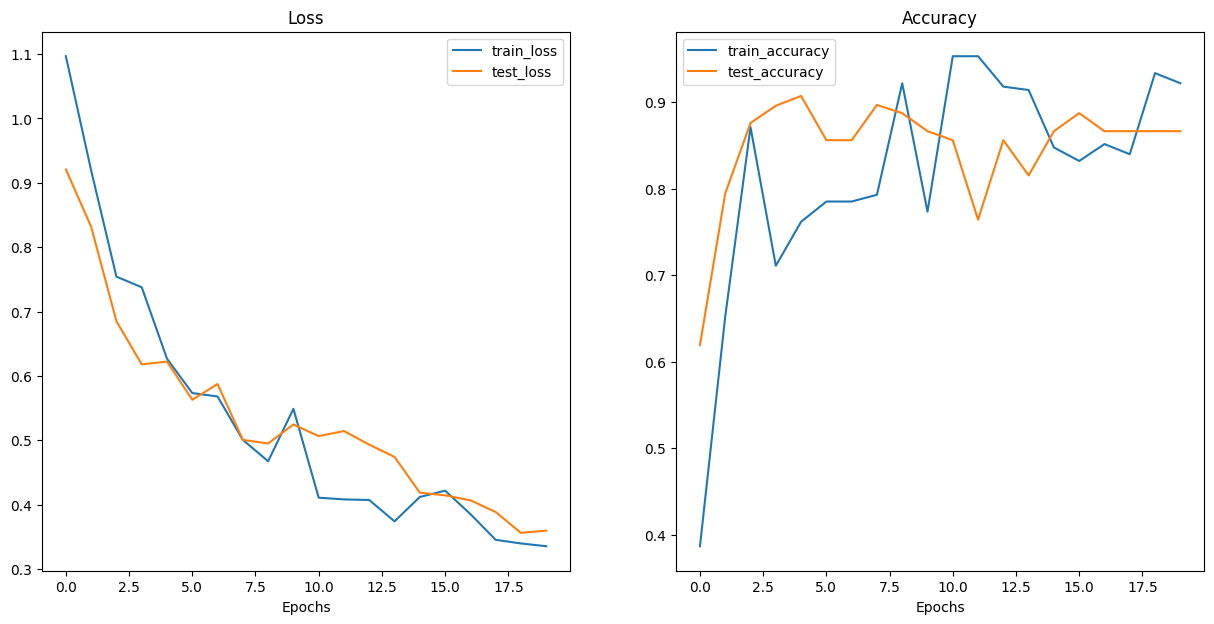

In [29]:
from helper_functions import plot_loss_curves  

plot_loss_curves(results) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


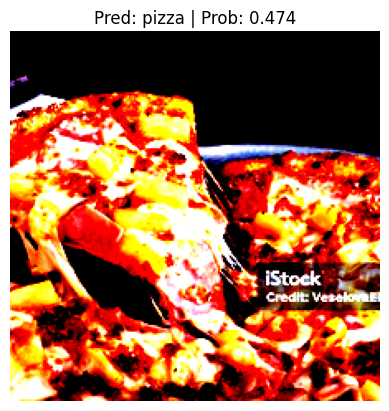

In [31]:
from helper_functions import pred_and_plot_image 

image_path = 'data/pizza_image_1024.jpg'
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, transform=auto_transforms, device=device) 

### EXP1 - custom transforms 

In [38]:
from going_modular import data_setup 
from torchvision import transforms 

train_dir = 'data/pizza_steak_sushi/train'
test_dir = 'data/pizza_steak_sushi/test'

custom_transforms = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor(), 
]) 

custom_train_dataloader, custom_test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, custom_transforms, 32) 
custom_train_dataloader, custom_test_dataloader, class_names 

(<torch.utils.data.dataloader.DataLoader at 0x18adc9b1c10>,
 ['pizza', 'steak', 'sushi'])

In [39]:
weights_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model_1 = torchvision.models.efficientnet_b0(weights=weights_1) 

for param in model_1.features.parameters(): 
    param.requires_grad = False 
    
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True) 
)

loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001) 


from going_modular import engine 
from timeit import default_timer as timer 

torch.manual_seed(42) 
torch.cuda.manual_seed(42) 

start_time = timer() 
results = engine.train(model=model_1, 
                       train_dataloader=custom_train_dataloader, 
                       test_dataloader=custom_test_dataloader, 
                       optimizer=optimizer, 
                       loss_fn=loss_fn, 
                       epochs=20, 
                       device=device) 

end_time = timer() 

print(f"[INFO] Total training time:; {end_time - start_time:.4f} sec") 

Epoch: 1 | train_loss: 1.0849 | train_acc: 0.4453 | test_loss: 0.9592 | test_acc: 0.6695
Epoch: 2 | train_loss: 0.9066 | train_acc: 0.6875 | test_loss: 0.8913 | test_acc: 0.7225
Epoch: 3 | train_loss: 0.7636 | train_acc: 0.7617 | test_loss: 0.6792 | test_acc: 0.8958
Epoch: 4 | train_loss: 0.7085 | train_acc: 0.7891 | test_loss: 0.6280 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6405 | train_acc: 0.7852 | test_loss: 0.6209 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5760 | train_acc: 0.9102 | test_loss: 0.5878 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6039 | train_acc: 0.7852 | test_loss: 0.5314 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5321 | train_acc: 0.9102 | test_loss: 0.4560 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.4460 | train_acc: 0.9023 | test_loss: 0.4193 | test_acc: 0.9167
Epoch: 10 | train_loss: 0.5442 | train_acc: 0.7695 | test_loss: 0.4040 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.4296 | train_acc: 0.9375 | test_loss: 0.3963 | test_acc: 0.9072
Epoch: 12 | train_l

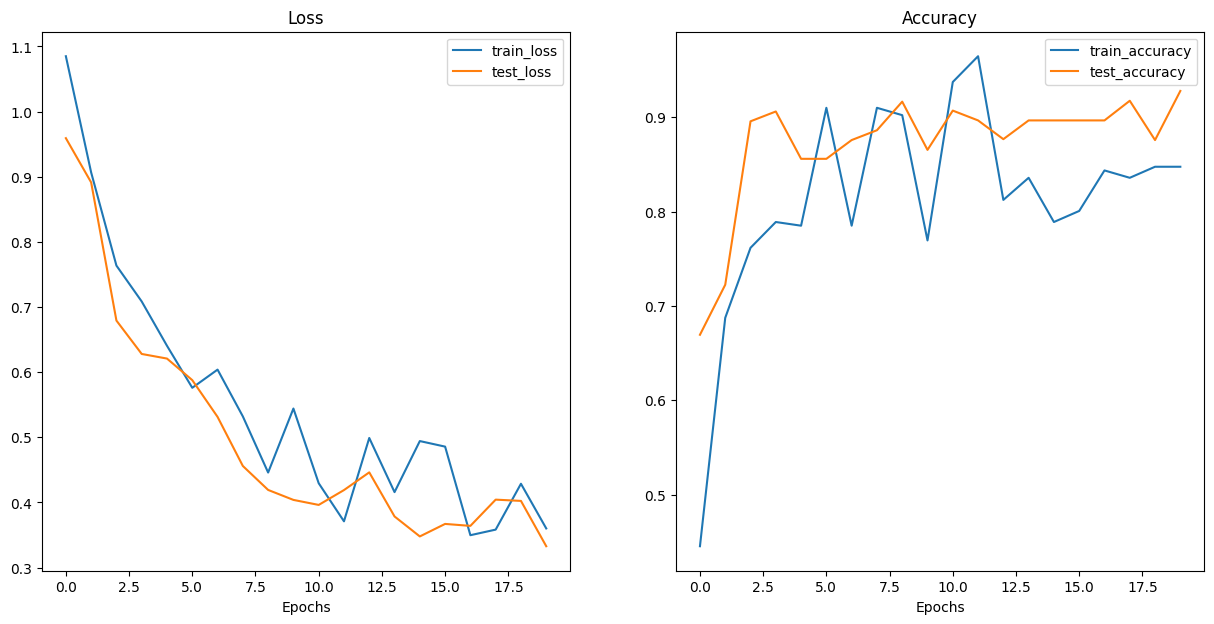

In [40]:
plot_loss_curves(results) 

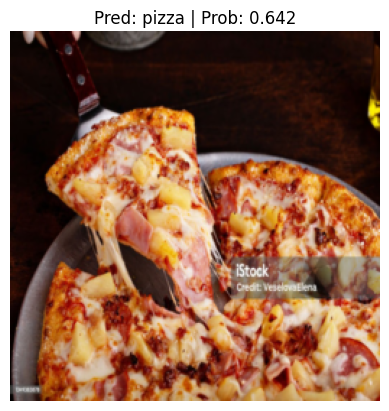

In [44]:
image_path = 'data/pizza_image_1024.jpg' 
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)), 
]) 
pred_and_plot_image(model=model_1, image_path=image_path, class_names=class_names, transform=test_transforms, device=device) 

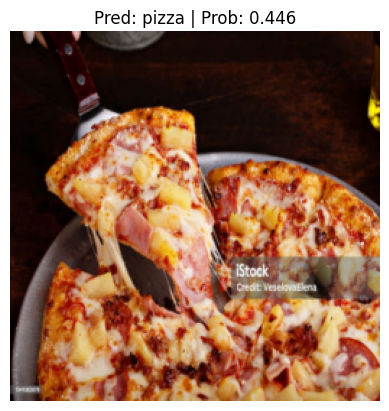

In [45]:
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, transform=test_transforms, device=device) 